In [1]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
from shapely.geometry import Point


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Grid radars based on date and time of interest

In [2]:
# Specify dates

# Cells date
cell_start_date = '2022-08-18T23:14:44'
cell_end_date = '2022-08-18T23:44:45'

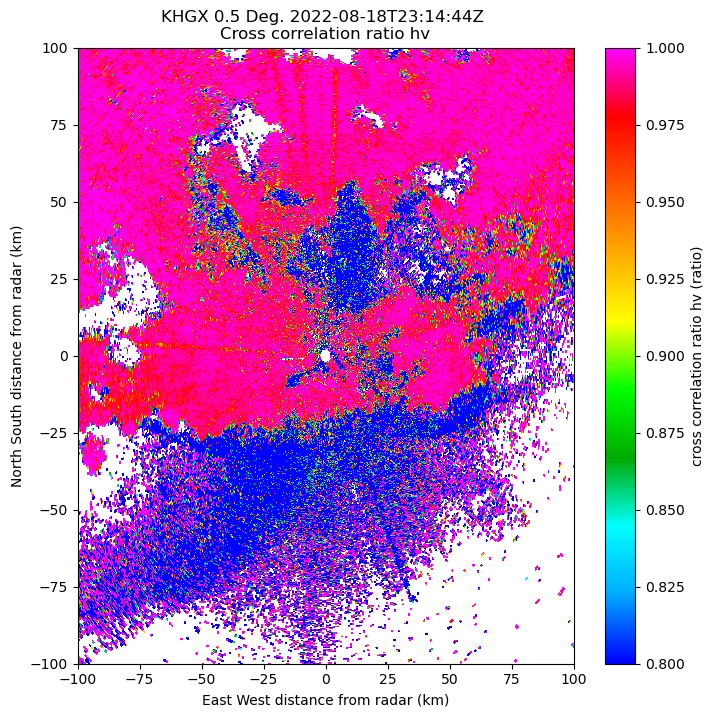

In [3]:
filename = "C:/Users/omitu/Desktop/KHGX/New/KHGX20220818_231444_V06"
radar = pyart.io.read(filename)
radar.fields.keys()

#Set weighting function
weight_func='Barnes' #nearest, Cressman

#Create a gatefilter
gfilter = pyart.filters.GateFilter(radar)
gfilter.exclude_below('cross_correlation_ratio',0.9)
#gfilter.exclude_below('reflectivity',20)

fig = plt.figure(figsize=(8,8))
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('cross_correlation_ratio',sweep=0,vmin=.8,vmax=1)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
#plt.savefig('Raw_Z.png')

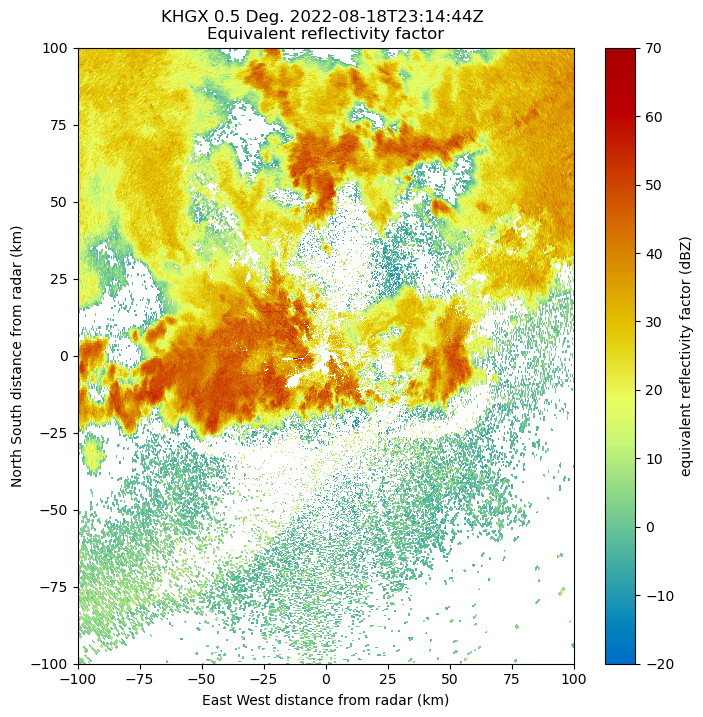

In [4]:
import pyart

# Load the radar data

# Now, you can use this gate filter in further processing or visualization
# For example, to create a plot that applies this filter
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, gatefilter=gfilter, ax=ax, vmin=-20, vmax=70)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
plt.show()

In [5]:
#KDP calc
kdp_calc = True

#Calculate KDP if desired
if(kdp_calc):
    kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar, gatefilter=gfilter, band='S', windsize=10, n_iter=10, interp=False,parallel=True)
    radar.add_field('kdp', kdp_vulpiani[0])

In [6]:
#Create a grid based on our radar object (z,y,x)
#Grid shape is number of points in each dimension
#Grid limits are the dimension limits in meters

grid = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 401, 401),
    gridding_algo = 'map_gates_to_grid',
    weighting_function = weight_func,
   # gatefilters = gfilter,
    grid_limits=(
        (
            0.0,
            20000,
        ),
        (-100000.0, 100000.0),
        (-100000, 100000.0),
    ),
)

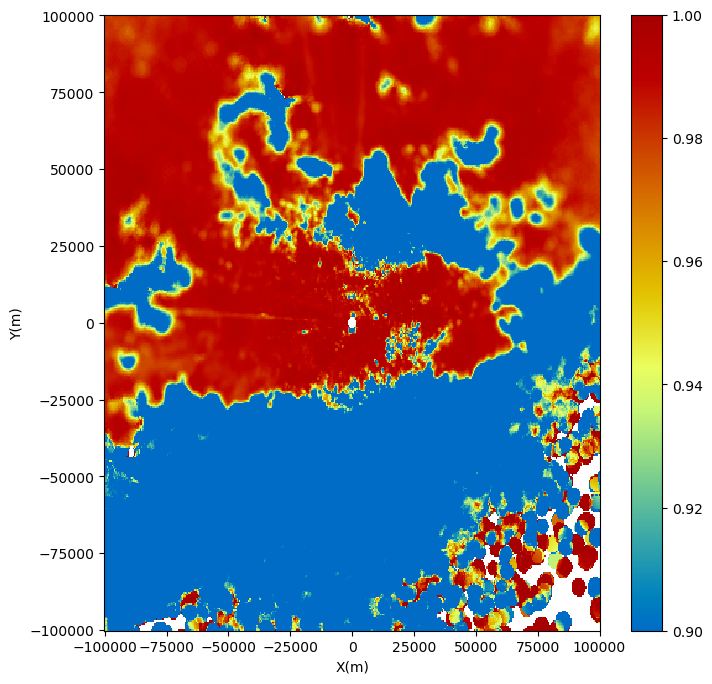

In [7]:
#grid.z["data"]
Z=grid.fields['reflectivity']['data']
rho=grid.fields['cross_correlation_ratio']['data']
ZDR=grid.fields['differential_reflectivity']['data']
kdp=grid.fields['kdp']['data']
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:

[X,Y]=np.meshgrid(grid.x["data"],grid.y["data"])
lev=2 #Level of analysis
fig = plt.figure(figsize=(8,8))
plt.pcolormesh(X,Y,np.squeeze(rho[lev,:,:]),cmap='pyart_HomeyerRainbow',vmin=0.9,vmax=1)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar()
plt.savefig('Strat_Z_'+weight_func+'.png')


#Z.shape

In [8]:
radar_grid = grid.to_xarray()

In [9]:
radar_grid

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 401, x: 401)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 28.57 28.57 ... 30.37 30.37
    lon                           (y, x) float64 -96.1 -96.1 ... -94.04 -94.04
  * y                             (y) float64 -1e+05 -9.95e+04 ... 1e+05
  * x                             (x) float64 -1e+05 -9.95e+04 ... 1e+05
Data variables:
    differential_phase            (time, z, y, x) float32 137.5 140.0 ... nan
    differential_reflectivity     (time, z, y, x) float32 8.111 8.052 ... nan
    reflectivity                  (time, z, y, x) float32 4.577 4.499 ... nan
    velocity                      (time, z, y, x) float32 nan nan ... nan nan
    clutter_filter_power_removed  (time, z, y, x) float32 -6.0 -6.0 ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.971 0.9616 ... nan
    spectrum_width                (time, z, y, x) float32 nan nan ... nan nan
    kdp                           (time, z, y, x) float64 0.1996 0.2096 ... nan
    ROI                           (time, z, y, x) float32 3.703e+03 ... 4.703...

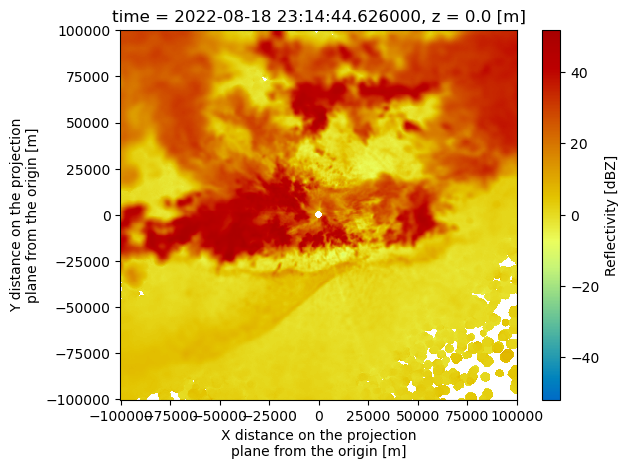

# Filter convective cells based on date and time of interest

In [10]:
tracked_cells = xr.open_dataset('C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/stats/trackstats_20220801.0000_20220831.2359.nc')
tracked_cells

<xarray.Dataset>
Dimensions:                  (tracks: 11705, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 11701 11702 11703 11704
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 ...
    base_time                (tracks, times) datetime64[ns] ...
    meanlat                  (tracks, times) float32 ...
    meanlon                  (tracks, times) float32 ...
    area                     (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    ...                       ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [11]:
# Define your time range
start_time = np.datetime64(cell_start_date)
end_time = np.datetime64(cell_end_date)

# Create a mask where base_time is within the specified range
time_mask = (tracked_cells.start_basetime >= start_time) & (tracked_cells.start_basetime <= end_time)

# Apply this mask across the 'tracks' dimension
filtered_ds = tracked_cells.where(time_mask, drop=True)
filtered_ds

<xarray.Dataset>
Dimensions:                  (tracks: 30, times: 100)
Coordinates:
  * tracks                   (tracks) int64 5355 5356 5357 ... 5382 5383 5384
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) float64 9.0 1.0 6.0 9.0 ... 2.0 3.0 2.0
    base_time                (tracks, times) datetime64[ns] 2022-08-18T23:14:...
    meanlat                  (tracks, times) float32 30.08 30.08 ... nan nan
    meanlon                  (tracks, times) float32 -94.8 -94.89 ... nan nan
    area                     (tracks, times) float32 118.8 192.2 ... nan nan
    cloudnumber              (tracks, times) float64 10.0 5.0 7.0 ... nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 5.294e+03 5.352e+03 ... nan nan
    start_split_timeindex    (tracks) float64 10.0 1.0 nan nan ... nan nan nan
    start_split_cloudnumber  (tracks) float64 3.0 18.0 nan nan ... nan nan nan
    end_merge_tracknumber    (tracks) float64 nan 5.352e+03 ... nan 5.329e+03
    end_merge_timeindex      (tracks) float64 nan 3.0 nan nan ... nan nan 12.0
    end_merge_cloudnumber    (tracks) float64 nan 12.0 nan nan ... nan nan 13.0
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [12]:
filtered_ds.cell_area.std()

<xarray.DataArray 'cell_area' ()>
array(51.81482315)

# Filter gridded radars based on convective cells

In [13]:
# Extract the coordinates from the convective cell data
latitudes = filtered_ds.cell_meanlat.values[~np.isnan(filtered_ds.cell_meanlat.values)]
longitudes = filtered_ds.cell_meanlon.values[~np.isnan(filtered_ds.cell_meanlon.values)]

In [14]:
latitudes

array([30.07652 , 30.075417, 30.061707, 30.039318, 30.032988, 30.04874 ,
       30.028456, 30.005054, 29.992987, 29.85139 , 29.549131, 29.454113,
       29.467813, 29.489902, 29.463783, 29.46346 , 29.336185, 29.31619 ,
       29.297054, 29.254856, 29.250422, 29.25523 , 29.258541, 29.265457,
       29.26132 , 30.45151 , 30.430939, 30.377039, 30.300587, 30.30018 ,
       30.271437, 30.232094, 30.20892 , 30.455376, 30.44688 , 30.433327,
       30.40316 , 30.376661, 30.318699, 30.280525, 30.24815 , 30.2231  ,
       30.195944, 30.162827, 30.135017, 30.120571, 29.38352 , 29.357048,
       29.345854, 29.36429 , 29.37481 , 29.35914 , 29.366064, 29.401165,
       29.976124, 29.370451, 29.9222  , 29.914122, 29.909523, 29.905058,
       29.293896, 29.972208, 29.954826, 29.941555, 30.11745 , 30.107662,
       30.450808, 30.442554, 30.431593, 30.402403, 29.410576, 29.253014,
       29.322403, 29.328642, 29.233173, 29.225061, 29.200613, 29.18501 ,
       29.161907, 29.153679, 29.126192, 29.14873 , 

In [15]:
latitudes.shape

(114,)

In [83]:
longitudes.shape

(114,)

In [84]:
longitudes

array([-94.79899 , -94.89176 , -94.881805, -94.87777 , -94.860245,
       -94.83772 , -94.84142 , -94.849075, -94.85822 , -94.63747 ,
       -94.7701  , -94.76863 , -94.71161 , -94.70805 , -94.706116,
       -94.75981 , -94.71212 , -94.678   , -94.68359 , -94.75858 ,
       -94.842995, -94.838646, -94.93796 , -94.92737 , -94.905846,
       -94.581726, -94.56508 , -94.498825, -94.53887 , -94.56521 ,
       -94.56693 , -94.547   , -94.55072 , -94.741554, -94.73908 ,
       -94.73833 , -94.743195, -94.74495 , -94.74458 , -94.741745,
       -94.7074  , -94.72621 , -94.7366  , -94.74974 , -94.7538  ,
       -94.762024, -95.28434 , -95.25296 , -95.25932 , -95.25725 ,
       -95.251366, -94.93214 , -94.926575, -94.424805, -94.70071 ,
       -95.93266 , -95.68486 , -95.6788  , -95.68317 , -95.685814,
       -94.83386 , -95.47596 , -95.46813 , -95.45641 , -95.47691 ,
       -95.45404 , -94.98161 , -94.98062 , -94.97645 , -94.968735,
       -95.472885, -94.878105, -94.69908 , -94.6847  , -95.636

In [107]:
# Buffer size (example: 0.01 degrees)
lat_buffer = 0.006   # This assures a buffer distance of 27 km
lon_buffer = 0.006   # This assures a buffer distance of 27 km

# Function to add buffers around points to reach a target number of points
def add_buffers(arr, buffer_size, target_length):
    # Calculate how many buffers to add around each point to approximate the target length
    num_buffers_per_point = (target_length - len(arr)) // (2 * len(arr))
    additional_points_needed = target_length - len(arr) - (2 * num_buffers_per_point * len(arr))
    
    new_points = []
    for point in arr:
        new_points.append(point)  # Add the original point
        # Generate buffers around each point
        for i in range(1, num_buffers_per_point + 1):
            new_points.append(point + i * buffer_size)
            new_points.append(point - i * buffer_size)
    
    # If additional points are needed, add them around the first point
    for i in range(1, additional_points_needed // 2 + 1):
        new_points.append(arr[0] + (num_buffers_per_point + i) * buffer_size)
        new_points.append(arr[0] - (num_buffers_per_point + i) * buffer_size)
    
    # Ensure the length matches the target length, trim if necessary
    return np.array(new_points[:target_length])

# Add buffers and generate new latitudes and longitudes
new_latitudes = add_buffers(latitudes, lat_buffer, 401)
new_longitudes = add_buffers(longitudes, lon_buffer, 401)


In [108]:
new_longitudes

array([-94.79898834, -94.79298834, -94.80498834, -94.89176178,
       -94.88576178, -94.89776178, -94.88180542, -94.87580542,
       -94.88780542, -94.87776947, -94.87176947, -94.88376947,
       -94.86024475, -94.85424475, -94.86624475, -94.83772278,
       -94.83172278, -94.84372278, -94.84142303, -94.83542303,
       -94.84742303, -94.84907532, -94.84307532, -94.85507532,
       -94.85822296, -94.85222296, -94.86422296, -94.63746643,
       -94.63146643, -94.64346643, -94.77010345, -94.76410345,
       -94.77610345, -94.76863098, -94.76263098, -94.77463098,
       -94.71160889, -94.70560889, -94.71760889, -94.70805359,
       -94.70205359, -94.71405359, -94.70611572, -94.70011572,
       -94.71211572, -94.7598114 , -94.7538114 , -94.7658114 ,
       -94.71212006, -94.70612006, -94.71812006, -94.6780014 ,
       -94.6720014 , -94.6840014 , -94.68359375, -94.67759375,
       -94.68959375, -94.75858307, -94.75258307, -94.76458307,
       -94.84299469, -94.83699469, -94.84899469, -94.83

In [109]:
new_latitudes

array([30.07652092, 30.08252092, 30.07052092, 30.07541656, 30.08141656,
       30.06941656, 30.06170654, 30.06770654, 30.05570654, 30.03931808,
       30.04531808, 30.03331808, 30.03298759, 30.03898759, 30.02698759,
       30.04874039, 30.05474039, 30.04274039, 30.02845573, 30.03445573,
       30.02245573, 30.00505447, 30.01105447, 29.99905447, 29.99298668,
       29.99898668, 29.98698668, 29.85139084, 29.85739084, 29.84539084,
       29.54913139, 29.55513139, 29.54313139, 29.45411301, 29.46011301,
       29.44811301, 29.46781349, 29.47381349, 29.46181349, 29.4899025 ,
       29.4959025 , 29.4839025 , 29.46378326, 29.46978326, 29.45778326,
       29.46346092, 29.46946092, 29.45746092, 29.33618546, 29.34218546,
       29.33018546, 29.31619072, 29.32219072, 29.31019072, 29.29705429,
       29.30305429, 29.29105429, 29.25485611, 29.26085611, 29.24885611,
       29.25042152, 29.25642152, 29.24442152, 29.25522995, 29.26122995,
       29.24922995, 29.25854111, 29.26454111, 29.25254111, 29.26

In [110]:
import numpy as np

def latlon2cart(latcoords, loncoords, latradar=29.4719, lonradar=-95.0787):
    # Ensure latcoords and loncoords are numpy arrays to handle element-wise operations
    latcoords = np.array(latcoords)
    loncoords = np.array(loncoords)
    
    # Earth's radius in kilometers
    r_earth = 6378.1
    
    # Convert latitude and longitude from degrees to radians
    phi_s = np.radians(latcoords)
    lambda_s = np.radians(loncoords)
    phi_f = np.radians(latradar)
    lambda_f = np.radians(lonradar)
    
    # Calculate differences in coordinates
    dlat = phi_f - phi_s
    dlon = lambda_f - lambda_s
    
    # Haversine formula to calculate the great-circle distance
    a = np.sin(dlat / 2)**2 + np.cos(phi_s) * np.cos(phi_f) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = r_earth * c
    
    # Calculate intermediate values for Cartesian conversion
    y1 = np.sin(dlon) * np.cos(phi_f)
    x1 = np.cos(phi_s) * np.sin(phi_f) - np.sin(phi_s) * np.cos(phi_f) * np.cos(dlon)
    
    # Calculate bearing (theta)
    theta = np.arctan2(y1, x1)
    
    # Convert to radar Cartesian coordinates and convert distance to meters
    x = d * np.sin(theta + np.pi) * 1000  # Convert to meters
    y = d * np.cos(theta + np.pi) * 1000  # Convert to meters
    
    # Round to the nearest 500 meters and ensure it does not exceed the bounds
    x_rounded = np.clip(500 * np.round(x / 500), -100000, 100000)
    y_rounded = np.clip(500 * np.round(y / 500), -100000, 100000)
    
    # Convert numpy arrays back to lists
    x_list = x_rounded.tolist()
    y_list = y_rounded.tolist()
    
    return x_list, y_list

gridlon, gridlat = latlon2cart(new_latitudes, new_longitudes)

In [111]:
tracked_cells.cell_meanlat.shape

(11705, 100)

In [115]:
radar_grid.lat.shape

(401, 401)

In [116]:
radar_grid

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 401, x: 401)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 28.57 28.57 ... 30.37 30.37
    lon                           (y, x) float64 -96.1 -96.1 ... -94.04 -94.04
  * y                             (y) float64 -1e+05 -9.95e+04 ... 1e+05
  * x                             (x) float64 -1e+05 -9.95e+04 ... 1e+05
Data variables:
    differential_phase            (time, z, y, x) float32 137.5 140.0 ... nan
    differential_reflectivity     (time, z, y, x) float32 8.111 8.052 ... nan
    reflectivity                  (time, z, y, x) float32 4.577 4.499 ... nan
    velocity                      (time, z, y, x) float32 nan nan ... nan nan
    clutter_filter_power_removed  (time, z, y, x) float32 -6.0 -6.0 ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.971 0.9616 ... nan
    spectrum_width                (time, z, y, x) float32 nan nan ... nan nan
    kdp                           (time, z, y, x) float64 0.1996 0.2096 ... nan
    ROI                           (time, z, y, x) float32 3.703e+03 ... 4.703...

In [163]:
merged_data

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 400, x: 400)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 30.08 30.08 30.08 ... 29.9 29.9
    lon                           (y, x) float64 -94.8 -94.79 ... -94.62 -94.98
  * y                             (y) float64 6.75e+04 6.8e+04 ... 4.75e+04
  * x                             (x) float64 2.7e+04 2.75e+04 ... 9.5e+03
Data variables:
    differential_phase            (time, z, y, x) float32 78.66 78.6 ... nan nan
    differential_reflectivity     (time, z, y, x) float32 0.9667 0.9521 ... nan
    reflectivity                  (time, z, y, x) float32 44.28 44.09 ... nan
    velocity                      (time, z, y, x) float32 0.4384 0.05461 ... nan
    clutter_filter_power_removed  (time, z, y, x) float32 nan nan ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.9922 0.9922 ... nan
    spectrum_width                (time, z, y, x) float32 1.606 1.629 ... nan
    kdp                           (time, z, y, x) float64 0.499 0.5026 ... nan
    ROI                           (time, z, y, x) float32 1.904e+03 ... 2.268...

In [117]:
radar_grid

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 401, x: 401)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 28.57 28.57 ... 30.37 30.37
    lon                           (y, x) float64 -96.1 -96.1 ... -94.04 -94.04
  * y                             (y) float64 -1e+05 -9.95e+04 ... 1e+05
  * x                             (x) float64 -1e+05 -9.95e+04 ... 1e+05
Data variables:
    differential_phase            (time, z, y, x) float32 137.5 140.0 ... nan
    differential_reflectivity     (time, z, y, x) float32 8.111 8.052 ... nan
    reflectivity                  (time, z, y, x) float32 4.577 4.499 ... nan
    velocity                      (time, z, y, x) float32 nan nan ... nan nan
    clutter_filter_power_removed  (time, z, y, x) float32 -6.0 -6.0 ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.971 0.9616 ... nan
    spectrum_width                (time, z, y, x) float32 nan nan ... nan nan
    kdp                           (time, z, y, x) float64 0.1996 0.2096 ... nan
    ROI                           (time, z, y, x) float32 3.703e+03 ... 4.703...

In [118]:
merged_data = radar_grid.sel(x=gridlon, y=gridlat, method='nearest')

In [119]:
merged_data

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 400, x: 400)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 30.08 30.08 30.08 ... 29.9 29.9
    lon                           (y, x) float64 -94.8 -94.79 ... -94.62 -94.98
  * y                             (y) float64 6.75e+04 6.8e+04 ... 4.75e+04
  * x                             (x) float64 2.7e+04 2.75e+04 ... 9.5e+03
Data variables:
    differential_phase            (time, z, y, x) float32 78.66 78.6 ... nan nan
    differential_reflectivity     (time, z, y, x) float32 0.9667 0.9521 ... nan
    reflectivity                  (time, z, y, x) float32 44.28 44.09 ... nan
    velocity                      (time, z, y, x) float32 0.4384 0.05461 ... nan
    clutter_filter_power_removed  (time, z, y, x) float32 nan nan ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.9922 0.9922 ... nan
    spectrum_width                (time, z, y, x) float32 1.606 1.629 ... nan
    kdp                           (time, z, y, x) float64 0.499 0.5026 ... nan
    ROI                           (time, z, y, x) float32 1.904e+03 ... 2.268...

In [165]:
sorted_data = merged_data.sortby('x')


In [167]:
sorted_data.sortby('y')

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 400, x: 400)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 29.06 29.06 ... 30.37 30.37
    lon                           (y, x) float64 -96.11 -96.11 ... -94.21 -94.21
  * y                             (y) float64 -4.55e+04 -4.5e+04 ... 1e+05 1e+05
  * x                             (x) float64 -1e+05 -1e+05 ... 8.3e+04 8.35e+04
Data variables:
    differential_phase            (time, z, y, x) float32 8.11 8.11 ... nan nan
    differential_reflectivity     (time, z, y, x) float32 nan nan ... nan nan
    reflectivity                  (time, z, y, x) float32 nan nan ... nan nan
    velocity                      (time, z, y, x) float32 -1.5 -1.5 ... nan nan
    clutter_filter_power_removed  (time, z, y, x) float32 -6.0 -6.0 ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 1.052 1.052 ... nan
    spectrum_width                (time, z, y, x) float32 1.5 1.5 ... nan nan
    kdp                           (time, z, y, x) float64 0.0 0.0 ... nan nan
    ROI                           (time, z, y, x) float32 2.877e+03 ... 4.411...

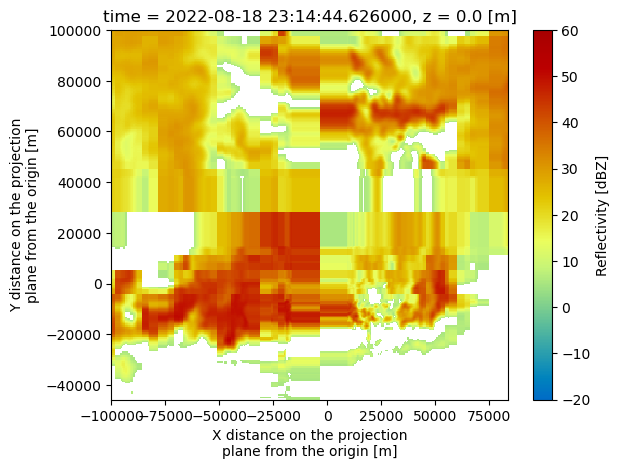

In [182]:
sorted_data.sortby('y').isel(z=0).reflectivity.plot(cmap='pyart_HomeyerRainbow', vmin=-20, vmax=60)

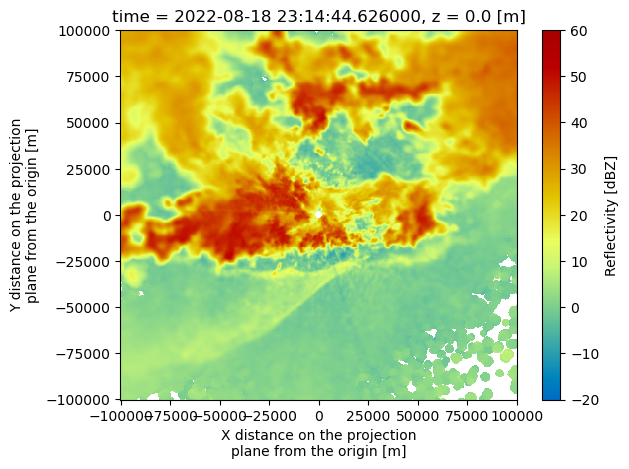

In [181]:
radar_grid.isel(z=0).reflectivity.plot(cmap='pyart_HomeyerRainbow', vmin=-20, vmax=60)

In [122]:
merged_data

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 400, x: 400)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 30.08 30.08 30.08 ... 29.9 29.9
    lon                           (y, x) float64 -94.8 -94.79 ... -94.62 -94.98
  * y                             (y) float64 6.75e+04 6.8e+04 ... 4.75e+04
  * x                             (x) float64 2.7e+04 2.75e+04 ... 9.5e+03
Data variables:
    differential_phase            (time, z, y, x) float32 78.66 78.6 ... nan nan
    differential_reflectivity     (time, z, y, x) float32 0.9667 0.9521 ... nan
    reflectivity                  (time, z, y, x) float32 44.28 44.09 ... nan
    velocity                      (time, z, y, x) float32 0.4384 0.05461 ... nan
    clutter_filter_power_removed  (time, z, y, x) float32 nan nan ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.9922 0.9922 ... nan
    spectrum_width                (time, z, y, x) float32 1.606 1.629 ... nan
    kdp                           (time, z, y, x) float64 0.499 0.5026 ... nan
    ROI                           (time, z, y, x) float32 1.904e+03 ... 2.268...

In [125]:
sorted_data = merged_data.sortby('y')


In [126]:
import xarray as xr
import numpy as np

# Assuming 'ds' is your xarray.Dataset
ds = merged_data  

# Only apply the condition to the 'reflectivity' variable
if 'reflectivity' in ds.data_vars:
    # Define the specific height condition for reflectivity below 3 km
    reflectivity_height_condition = ds['z'] < 5000
    # Apply condition for reflectivity: height below 3 km and reflectivity value below 20
    reflectivity_condition = ds['reflectivity'] < 5
    combined_condition = reflectivity_height_condition & reflectivity_condition
    ds['reflectivity'] = ds['reflectivity'].where(~combined_condition, np.nan)


# Only apply the condition to the 'reflectivity' variable
if 'cross_correlation_ratio' in ds.data_vars:
    # Define the specific height condition for reflectivity below 3 km
    reflectivity_height_condition = ds['z'] < 5000
    # Apply condition for reflectivity: height below 3 km and reflectivity value below 20
    reflectivity_condition_1 =  ds['cross_correlation_ratio'] > 1.02 
    reflectivity_condition_2 =  ds['cross_correlation_ratio'] < 0.8 
    combined_condition = reflectivity_height_condition & reflectivity_condition_1 & reflectivity_condition_2
    ds['cross_correlation_ratio'] = ds['cross_correlation_ratio'].where(~combined_condition, np.nan)


# Only apply the condition to the 'reflectivity' variable
if 'differential_reflectivity' in ds.data_vars:
    # Define the specific height condition for reflectivity below 3 km
    reflectivity_height_condition = ds['z'] < 5000
    # Apply condition for reflectivity: height below 3 km and reflectivity value below 20
    reflectivity_condition = ds['differential_reflectivity'] > 6 
    combined_condition = reflectivity_height_condition & reflectivity_condition
    ds['differential_reflectivity'] = ds['differential_reflectivity'].where(~combined_condition, np.nan)


In [127]:
merged_data = ds

In [128]:
merged_data

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 400, x: 400)
Coordinates:
  * time                          (time) object 2022-08-18 23:14:44.626000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 30.08 30.08 30.08 ... 29.9 29.9
    lon                           (y, x) float64 -94.8 -94.79 ... -94.62 -94.98
  * y                             (y) float64 6.75e+04 6.8e+04 ... 4.75e+04
  * x                             (x) float64 2.7e+04 2.75e+04 ... 9.5e+03
Data variables:
    differential_phase            (time, z, y, x) float32 78.66 78.6 ... nan nan
    differential_reflectivity     (time, z, y, x) float32 0.9667 0.9521 ... nan
    reflectivity                  (time, z, y, x) float32 44.28 44.09 ... nan
    velocity                      (time, z, y, x) float32 0.4384 0.05461 ... nan
    clutter_filter_power_removed  (time, z, y, x) float32 nan nan ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 0.9922 0.9922 ... nan
    spectrum_width                (time, z, y, x) float32 1.606 1.629 ... nan
    kdp                           (time, z, y, x) float64 0.499 0.5026 ... nan
    ROI                           (time, z, y, x) float32 1.904e+03 ... 2.268...

# COntinue with CFAD

In [129]:
#CFAD settings
zlims=[-20, 65]
zdrlims=[-1, 3]
rholims=[0.9, 1.02]
kdplims=[-1,3]
#lims = [-50000,0,-75000,30000]
lims=[-100000,-50000,-50000,50000]
#lims = [-50000,50000,-50000,50000]
ymax=10
norm_opt = 2 #1) Normalize at each height only, 2) Normalize across all heights

#CFAD increment
dz = 3
dzdr = 0.5
drho = 0.0025
dkdp = 0.1

In [130]:
# Function to apply masking and squeezing
def process_variable(data_array):
    # Extract the numpy array from the DataArray
    np_array = data_array.values
    
    # Define the mask condition
    mask_condition = np.isnan(np_array)
    
    # Apply the mask to create a masked array
    masked_array_np = np.ma.masked_where(mask_condition, np_array)
    
    # Squeeze the masked array to remove the singleton dimension
    squeezed_masked_array = np.squeeze(masked_array_np)
    
    # Return the processed masked array
    return squeezed_masked_array

In [131]:
differential_reflectivity = merged_data['differential_reflectivity']
masked_differential_reflectivity = process_variable(differential_reflectivity)

kdp = merged_data['kdp']
masked_kdp = process_variable(kdp)

cross_correlation_ratio = merged_data['cross_correlation_ratio']
masked_cross_correlation_ratio = process_variable(cross_correlation_ratio)

reflectivity = merged_data['reflectivity']
masked_reflectivity = process_variable(reflectivity)

In [172]:
[X, Y] = np.meshgrid(merged_data.x, merged_data.y)

In [188]:
X.shape

(400, 400)

In [189]:
Y.shape

(400, 400)

In [177]:
merged_data.x.shape

(400,)

In [187]:
merged_data.y.shape

(400,)

In [185]:
merged_data.x.shape

(400,)

In [133]:
lims

[-100000, -50000, -50000, 50000]

In [134]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a,b])
        else:
            data_hist = np.ma.compressed(data[lev,:,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a,b],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data =  masked_reflectivity
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = masked_differential_reflectivity
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = masked_cross_correlation_ratio
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = masked_kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

In [183]:
masked_reflectivity.shape

(41, 400, 400)

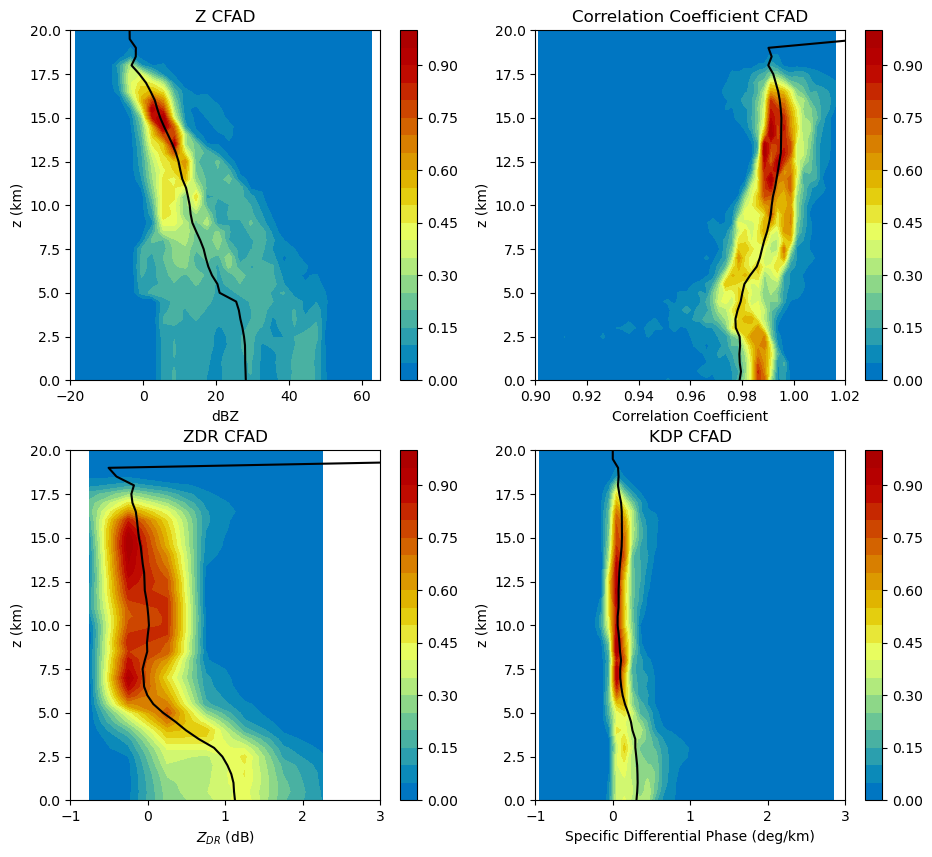

In [135]:
#Plotting levels for contours
ymax=20
fig,ax = plt.subplots(2,2,figsize=(11,10))
[z,b]=np.meshgrid(grid.z["data"],Zctr)
pcm=ax[0,0].contourf(b,z/1000,hist_Z,levels=20,cmap='pyart_HomeyerRainbow')
ax[0,0].plot(meanZ,grid.z["data"]/1000,'-k')
#ax[0,0].contour(b,z/1000,hist_Z,levels=np.arange(0.05,1,0.05),colors='k')
ax[0,0].set_xlabel('dBZ')
ax[0,0].set_ylabel('z (km)')
ax[0,0].set_title('Z CFAD')
#ax[0,0].set_title('Z CFAD (% of Data per dBZ per km)')
ax[0,0].set_xlim(zlims)
ax[0,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,0])

[z,b]=np.meshgrid(grid.z["data"],ZDRctr)
pcm=ax[1,0].contourf(b,z/1000,hist_ZDR,levels=20,cmap='pyart_HomeyerRainbow')
#ax[1,0].contour(b,z/1000,hist_ZDR,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[1,0].plot(meanZDR,grid.z["data"]/1000,'-k')
ax[1,0].set_xlabel('$Z_{DR}$ (dB)')
ax[1,0].set_ylabel('z (km)')
#ax[1,0].set_title('ZDR CFAD (% of Data per 0.1 dB per km)')
ax[1,0].set_title('ZDR CFAD')
ax[1,0].set_xlim(zdrlims)
ax[1,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[1,0])

[z,b]=np.meshgrid(grid.z["data"],rhoctr)
pcm=ax[0,1].contourf(b,z/1000,hist_rho,levels=20,cmap='pyart_HomeyerRainbow')
#ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[0,1].plot(meanrho,grid.z["data"]/1000,'-k')
ax[0,1].set_xlabel('Correlation Coefficient')
ax[0,1].set_ylabel('z (km)')
#ax[0,1].set_title('Correlation Coefficient CFAD (% of Data per 0.001 CC per km)')
ax[0,1].set_title('Correlation Coefficient CFAD')
ax[0,1].set_xlim(rholims)
ax[0,1].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,1])

if(kdp_calc):
    [z,b]=np.meshgrid(grid.z["data"],kdpctr)
    pcm=ax[1,1].contourf(b,z/1000,hist_kdp,levels=20,cmap='pyart_HomeyerRainbow')
    #ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
    ax[1,1].plot(meankdp,grid.z["data"]/1000,'-k')
    ax[1,1].set_xlabel('Specific Differential Phase (deg/km)')
    #ax[1,1].set_title('KDP CFAD (% of Data per 0.01 deg/km per km)')
    ax[1,1].set_title('KDP CFAD')
    ax[1,1].set_ylabel('z (km)')
    ax[1,1].set_ylim(0,ymax)
    ax[1,1].set_xlim(kdplims)
    fig.colorbar(pcm, ax=ax[1,1])

fig.savefig('CFAD_norm_1.png')

In [136]:
import numpy as np

# Assuming gate_altitudes is already calculated and available
# For example:
gate_altitudes = radar.gate_altitude['data']

import numpy as np

# Assuming gate_altitudes and radar object are already available

# Define the altitude threshold (3 km) and CCR threshold (0.9)
altitude_threshold = 3000  # meters
ccr_threshold = 0.9

# Access the cross_correlation_ratio and reflectivity data
ccr_data = radar.fields['cross_correlation_ratio']['data']
reflectivity_data = radar.fields['reflectivity']['data']

# Find indices where altitude is below 3 km
indices_below_altitude_threshold = np.where(gate_altitudes < altitude_threshold)

# For CCR: Apply the threshold conditionally
ccr_below_threshold_at_low_altitude = ccr_data[indices_below_altitude_threshold] < ccr_threshold
ccr_data[indices_below_altitude_threshold] = np.where(ccr_below_threshold_at_low_altitude, np.nan, ccr_data[indices_below_altitude_threshold])

# Assuming you want to apply a similar logic to reflectivity under the same altitude condition
# Here, you might define a specific reflectivity threshold or use the CCR condition as above
# For simplicity, let's apply the same CCR condition to mask reflectivity
# Note: This is conceptual. Adjust the condition based on your specific needs for reflectivity
reflectivity_data[indices_below_altitude_threshold] = np.where(ccr_below_threshold_at_low_altitude, np.nan, reflectivity_data[indices_below_altitude_threshold])

# Update the radar object with the modified data
radar.fields['cross_correlation_ratio']['data'] = ccr_data
radar.fields['reflectivity']['data'] = reflectivity_data


# Characterize the near-storm environment

## Case 1: Comparing environments with different cell properties

In [137]:
# Here, we would be using the data based on the period of the storm, i.e. August 10, 22:00 UTC to August 11, 04:00 UTC

In [138]:
%store -r stats

In [139]:
# Define your time range
start_time = np.datetime64('2022-06-01T00:00:30')
end_time = np.datetime64('2022-08-31T23:59:30')

# Create a mask where base_time is within the specified range
time_mask = (stats.start_basetime >= start_time) & (stats.start_basetime <= end_time)

# Apply this mask across the 'tracks' dimension
filtered_ds = stats.where(time_mask, drop=True)
filtered_ds

<xarray.Dataset>
Dimensions:                  (tracks: 21727, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 25331 25332 25333 25334
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) float64 7.0 3.0 18.0 15.0 ... 1.0 3.0 8.0
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 1.167e+04 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 16.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 1.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [140]:
# Convection initiation classification based on Marquis et al., 2022

# Long-lived vs sgort-lived cells: Total duration >= 3 or less than 3 consecutive radar volumes, respectively
# Deep or shallow cells: 20-dBZ echo-top height (ETH) >= 66% or < 66% of the MU EL height, respectively
# Wide or narrow cells: cell area >= 50 km2 or < 50 km2, respectively.
# Intense or weak cells: 

In [141]:
# Analyze each track using list comprehensions
data = filtered_ds
tracks_with_6_or_more_consecutive = [i for i, track in enumerate(data['cell_area'].values) if not np.isnan(track[:6]).any()]
tracks_with_less_than_6_consecutive = [i for i, track in enumerate(data['cell_area'].values) if np.isnan(track[:6]).any()]

# Translate indices back to track IDs
long_lived_tracks = data.tracks.values[tracks_with_6_or_more_consecutive]
short_lived_tracks = data.tracks.values[tracks_with_less_than_6_consecutive]


# Print results
print(f"Number of long-lived tracks: {len(long_lived_tracks)}")
print(f"Number of short_lived tracks: {len(short_lived_tracks)}")
# print(f"\nTracks with less than 3 consecutive non-NaN volumes from the start: {len(short_lived_tracks)}")
# print("Track IDs:", short_lived_tracks)


Number of long-lived tracks: 8271
Number of short_lived tracks: 13456


In [142]:
long_lived_tracks

array([    0,     2,     3, ..., 25313, 25315, 25334], dtype=int64)

In [143]:
# Classify tracks based solely on area criteria without checking for NaN values
tracks_with_area_50_or_more = [i for i, track in enumerate(data['area'].values) 
                               if all(area >= 50 for area in track[:6])]
tracks_with_area_less_than_50 = [i for i, track in enumerate(data['area'].values) 
                                 if any(area < 50 for area in track[:6])]

# Translate indices to track IDs
wide_cells = data.tracks.values[tracks_with_area_50_or_more]
narrow_cells = data.tracks.values[tracks_with_area_less_than_50]

# Output results
print(f"Number of wide tracks: {len(wide_cells)}")
print(f"Number of narrow tracks: {len(narrow_cells)}")

Number of wide tracks: 327
Number of narrow tracks: 20807


In [144]:
import xarray as xr

# Load the convective cell data
conv_cells_data = filtered_ds

# Determine deep (ETH >= 10 km) and shallow (ETH < 10 km) cells from maxETH_20dbz in the first six time points
deep_threshold_km = 10
max_eth_first_3 = data['maxETH_20dbz'].isel(times=slice(0, 6)).max(dim='times')
deep_cells = max_eth_first_3.where(max_eth_first_3 >= deep_threshold_km, drop=True).tracks.values
shallow_cells = max_eth_first_3.where(max_eth_first_3 < deep_threshold_km, drop=True).tracks.values

# Print counts and example track IDs
print(f"Number of deep cells: {len(deep_cells)}")
print(f"Number of shallow cells: {len(shallow_cells)}")


Number of deep cells: 3741
Number of shallow cells: 17453


In [145]:
# Define the threshold for classifying intense cells
intense_threshold_dbz = 50

# Classify cells as intense or weak based on max_dbz within the first six volumes
intense_cells = data['max_dbz'].isel(times=slice(0, 6)).max(dim='times').where(lambda x: x >= intense_threshold_dbz, drop=True).tracks.values
weak_cells = data['max_dbz'].isel(times=slice(0, 6)).max(dim='times').where(lambda x: x < intense_threshold_dbz, drop=True).tracks.values

# Output counts and example track IDs
print(f"Intense cells: {len(intense_cells)}")
print(f"Weak cells: {len(weak_cells)}")


Intense cells: 1587
Weak cells: 20140


In [146]:
filtered_ds.base_time

<xarray.DataArray 'base_time' (tracks: 21727, times: 100)>
array([['2022-06-01T00:01:39.889999872', '2022-06-01T00:05:22.660000000',
        '2022-06-01T00:09:04.704000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2022-06-01T00:01:39.889999872', '2022-06-01T00:05:22.660000000',
        '2022-06-01T00:09:04.704000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2022-06-01T00:01:39.889999872', '2022-06-01T00:05:22.660000000',
        '2022-06-01T00:09:04.704000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2022-08-31T22:57:30.164999936',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2022-08-31T23:03:33.900999936', '2022-08-31T23:09:28.684999936',
        '2022-08-31T23:15:13.536000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2022-08-31T23:20:42.420999936', '2022-08-31T23:26:01.147000064',
        '2022-08-31T23:31:24.008000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 25329 25330 25331 25332 25333 25334
  * times    (times) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  Epoch time of a feature

In [147]:
# Calculate the maximum area of the first four radar volumes for each track
max_area_first_4 = np.nanmax(data['area'].values[:, :4], axis=1)

# You can then use this data directly, or if you need to associate it with track IDs:
tracks = data.tracks.values
max_area_per_track = [(track_id, area) for track_id, area in zip(tracks, max_area_first_4)]

# Output the maximum area for the first track as an example
print(f"Track ID: {max_area_per_track[0][0]}, Max Area (first 4 volumes): {max_area_per_track[0][1]}")


Track ID: 0, Max Area (first 4 volumes): 20.5


In [148]:
import numpy as np

# Assuming data['area'].values contains the area data
max_area_first_4 = np.nanmax(data['area'].values[:, :4], axis=1)
num_cells_less_than_50_km2 = np.sum(max_area_first_4 > 50)

print(f"Number of cells with max area < 50 km² in the first 4 volumes: {num_cells_less_than_50_km2}")


Number of cells with max area < 50 km² in the first 4 volumes: 3226


In [149]:
# Calculate and print percentages for each pair of variables
def calculate_and_print_percentages(set1, set2, set1_name, set2_name):
    intersection = np.intersect1d(set1, set2)
    percentage_set1 = (len(intersection) / len(set1)) * 100
    percentage_set2 = (len(intersection) / len(set2)) * 100
    print(f'{round(percentage_set1)}% of {set1_name} are also {set2_name}')
    print(f'{round(percentage_set2)}% of {set2_name} are also {set1_name}')

# Example calls
calculate_and_print_percentages(long_lived_tracks, deep_cells, "long-lived tracks", "deep cells")
calculate_and_print_percentages(short_lived_tracks, shallow_cells, "short-lived tracks", "shallow cells")
calculate_and_print_percentages(wide_cells, intense_cells, "wide cells", "intense cells")
calculate_and_print_percentages(narrow_cells, weak_cells, "narrow cells", "weak cells")
calculate_and_print_percentages(narrow_cells, deep_cells, "narrow cells", "deep cells")


30% of long-lived tracks are also deep cells
66% of deep cells are also long-lived tracks
87% of short-lived tracks are also shallow cells
67% of shallow cells are also short-lived tracks
65% of wide cells are also intense cells
13% of intense cells are also wide cells
94% of narrow cells are also weak cells
98% of weak cells are also narrow cells
15% of narrow cells are also deep cells
83% of deep cells are also narrow cells


In [150]:
# Extract the base times of each cell property

times_wide_cells = np.unique(filtered_ds.sel(tracks=wide_cells).start_basetime.values)
times_narrow_cells = np.unique(filtered_ds.sel(tracks=narrow_cells).start_basetime.values)
times_deep_cells = np.unique(filtered_ds.sel(tracks=deep_cells).start_basetime.values)
times_shallow_cells = np.unique(filtered_ds.sel(tracks=shallow_cells).start_basetime.values)
times_long_lived_cells = np.unique(filtered_ds.sel(tracks=long_lived_tracks).start_basetime.values)
times_short_lived_cells = np.unique(filtered_ds.sel(tracks=short_lived_tracks).start_basetime.values)
times_intense_cells = np.unique(filtered_ds.sel(tracks=intense_cells).start_basetime.values)
times_weak_cells = np.unique(filtered_ds.sel(tracks=weak_cells).start_basetime.values)

In [190]:
len(times_wide_cells)

29

In [151]:
import numpy as np

# Find unique elements in each array and convert back to arrays
times_wide_cells = np.array(list(set(times_wide_cells) - set(times_narrow_cells)))
times_narrow_cells = np.array(list(set(times_narrow_cells) - set(times_wide_cells)))
times_deep_cells = np.array(list(set(times_deep_cells) - set(times_shallow_cells)))
times_shallow_cells = np.array(list(set(times_shallow_cells) - set(times_deep_cells)))
times_long_lived_cells = np.array(list(set(times_long_lived_cells) - set(times_short_lived_cells)))
times_short_lived_cells = np.array(list(set(times_short_lived_cells) - set(times_long_lived_cells)))
times_intense_cells = np.array(list(set(times_intense_cells) - set(times_weak_cells)))
times_weak_cells = np.array(list(set(times_weak_cells) - set(times_intense_cells)))


In [152]:
import pandas as pd

# Function to calculate the minute number from 2022-01-01
def calculate_minute_number(datetime_value):
    # Define start date
    start_date = pd.Timestamp('2022-06-01 00:00:30')
    
    # Convert input to Timestamp
    datetime_value = pd.Timestamp(datetime_value)
    
    # Calculate the difference in minutes
    difference = (datetime_value - start_date).total_seconds() / 60
    
    return int(difference)

# Example datetime values
datetime_values = times_wide_cells

# Calculate minute numbers for each datetime value
minute_numbers = [calculate_minute_number(dt) for dt in datetime_values]




In [153]:
import pandas as pd

# Function to calculate the minute number from 2022-06-01
def calculate_minute_number(datetime_value):
    # Define start date
    start_date = pd.Timestamp('2022-06-01 00:00:30')
    
    # Convert input to Timestamp
    datetime_value = pd.Timestamp(datetime_value)
    
    # Calculate the difference in minutes
    difference = (datetime_value - start_date).total_seconds() / 60
    
    return int(difference)

# Example arrays of datetime values (replace with your actual arrays)
datetime_arrays = [times_wide_cells, times_narrow_cells, times_deep_cells, times_shallow_cells,
                 times_long_lived_cells, times_short_lived_cells, times_intense_cells, times_weak_cells   ]  # Assuming times_wide_cells and times_narrow_cells are defined

# Calculate minute numbers for each array and store results in a list of lists
all_minute_numbers = [[calculate_minute_number(dt) for dt in datetime_array] for datetime_array in datetime_arrays]



In [154]:
%store all_minute_numbers filtered_ds

Stored 'all_minute_numbers' (list)
Stored 'filtered_ds' (Dataset)


## Case 2: Comparing environments of different regions

In [155]:
%store -r clipped_urban_circle clipped_downwind_wedge clipped_upwind_wedge city_center

In [156]:
cell_lon = filtered_ds['cell_meanlon']
cell_lat = filtered_ds['cell_meanlat']
start_time = filtered_ds['start_basetime']

start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)
start_hour = start_time.dt.hour

storm_points = [Point(lon, lat) for lon, lat in zip(start_lon, start_lat)]

In [157]:
# Initiation at urban area
def lat_lon_to_cartesian(lat, lon, R=6371):
    x = R * np.radians(lon)
    y = R * np.radians(lat)
    return x, y

center_lat, center_lon, radius = city_center[1], city_center[0], 76.35
center_x, center_y = lat_lon_to_cartesian(center_lat, center_lon)
storm_x, storm_y = lat_lon_to_cartesian(start_lat, start_lon)
distances = np.sqrt((storm_x - center_x)**2 + (storm_y - center_y)**2)
storms_in_circle = start_hour[distances <= radius]

circle = storms_in_circle.tracks.values
stats_urban = filtered_ds.sel(tracks=circle)

In [158]:
storms_in_upwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_upwind_wedge.contains(point)]
storms_in_upwind_wedge = xr.concat(storms_in_upwind_wedge, dim='tracks')
upwind = storms_in_upwind_wedge.tracks.values
stats_upwind = filtered_ds.sel(tracks=upwind)

storms_in_downwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_downwind_wedge.contains(point)]
storms_in_downwind_wedge = xr.concat(storms_in_downwind_wedge, dim='tracks')
downwind = storms_in_downwind_wedge.tracks.values
stats_downwind = filtered_ds.sel(tracks=downwind)

In [159]:
times_upwind = np.unique(stats_upwind.start_basetime.values)
times_urban = np.unique(stats_urban.start_basetime.values)
times_downwind = np.unique(stats_downwind.start_basetime.values)

In [160]:
times_upwind = np.array(list(set(times_upwind) - set(times_urban) - set(times_downwind)))
times_urban = np.array(list(set(times_urban) - set(times_upwind) - set(times_downwind)))
times_downwind = np.array(list(set(times_downwind) - set(times_upwind) - set(times_urban)))

In [161]:
import pandas as pd

# Function to calculate the minute number from 2022-06-01
def calculate_minute_number(datetime_value):
    # Define start date
    start_date = pd.Timestamp('2022-06-01 00:00:30')
    
    # Convert input to Timestamp
    datetime_value = pd.Timestamp(datetime_value)
    
    # Calculate the difference in minutes
    difference = (datetime_value - start_date).total_seconds() / 60
    
    return int(difference)

# Example arrays of datetime values (replace with your actual arrays)
datetime_arrays = [times_upwind, times_urban, times_downwind]  # Assuming times_wide_cells and times_narrow_cells are defined

# Calculate minute numbers for each array and store results in a list of lists
all_minute_numbers_regions = [[calculate_minute_number(dt) for dt in datetime_array] for datetime_array in datetime_arrays]



In [162]:
%store all_minute_numbers_regions stats_urban stats_upwind stats_downwind

Stored 'all_minute_numbers_regions' (list)
Stored 'stats_urban' (Dataset)
Stored 'stats_upwind' (Dataset)
Stored 'stats_downwind' (Dataset)
